## Modules Used

In [121]:
# Modules used to connect to coppelia
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [122]:
# Other Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate
import os
import networkx as nx
from copy import deepcopy
from time import sleep

In [123]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

sim.stopSimulation()
sleep(1)


## Funções


### Create Wavefront

Abre a imagem que representa o mapa que o robô terá que navegar

In [124]:
def openImage(imgPath, threshold = 0.5):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Invertendo os valores para visualização (Branco - 0, Preto - 1)
    img = 1 - mpimg.imread(imgPath)

    # Apenas para garantir que só teremos esses dois valores
    img[img > threshold] = 1
    img[img<= threshold] = 0

    ax.imshow(img, cmap='Greys', origin='upper')

    return img

Função que Discretiza o Ambiente

In [125]:
# img -> Uma matriz numpy da Imagem
# map_dims -> Dimensões do mapa informado em metros (X, Y)
# cell_size -> Tamanho da célula do nosso Grid (em metros)
def discretizesTheEnvironment(img, map_dims, cell_size, threshold):

    # Escala Pixel/Metro
    sy, sx = img.shape / map_dims

    rows, cols = (map_dims / cell_size).astype(int)
    grid = np.zeros((rows, cols))


    # Preenchendo o Grid
    # Cada célula recebe o somatório dos valores dos Pixels
    for r in range(rows):
        for c in range(cols):
            
            # c*cell -> inicio da celula no mapa real (em metros)
            # sx -> Escala
            # c*cell*sx -> o inicio da celula porem na representação do mapa (pixel)
            xi = int(c*cell_size*sx)
            xf = int(xi + cell_size*sx)
            
            yi = int(r*cell_size*sy)
            yf = int(yi + cell_size*sy)
                        
            grid[r, c] = np.sum(img[yi:yf,xi:xf])

    # Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
    grid[grid > threshold] = 1
    grid[grid<= threshold] = 0 

    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
    ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

    return grid


Creating the wavefront

In [126]:
def initWavefront(wave):
    nRows, nCols = wave.shape

    for r in range(nRows):
        for c in range(nCols):
            # Lugares que tem obstáculo coloca como infinito
            wave[r][c] = np.Inf if wave[r][c] == 1 else -1 


Função que cria o wavefront dado um objetivo

In [127]:
def cellNeighbors(M, cell:tuple, queue:list, pos:list):
    x, y = cell
    actualCost = M[x][y]

    nRows, nCols = M.shape

    for p in pos:
        dx, dy = p

        # Verifica os limites
        if (x + dx < 0 or y + dy < 0): continue
        if (x + dx >= nRows or y + dy >= nCols): continue
        
        # Pega o valor da celula vizinha
        neighborC = M[x + dx][y + dy]
        
        # Se vizinho é um obstáculo
        if neighborC == np.Inf: continue
        
        # Se o vizinho nunca foi explorado anteriormente
        # Coloca ele na fila (queue)
        if neighborC == -1:
            M[x + dx][y + dy] = actualCost + 1
            queue.append((x + dx, y + dy))
        
        if neighborC > actualCost:
            M[x + dx][y + dy] = actualCost + 1


In [128]:
def waveFront(M, goal, pos):
    M[goal[0]][goal[1]] = 0
    queue = [goal]
    
    while len(queue) != 0:
        cell = queue.pop(0)
        cellNeighbors(M, cell, queue, pos)
    

### Função para converter meters to wavefront cells and vice versa

Eixos e Origem da utilizados no Wavefront

![image-2.png](attachment:image-2.png)


Eixos e Origem (deslocada para o canto do mapa) do Mapa do Coppelia

![image.png](attachment:image.png)

Como os eixos e origem das duas representaçãoes não são o mesmo
É necessário ter uma função que faça o mapeamento de uma representação para outra

Eixos: Os eixos das duas representações são invertidos comparando um com o outro
Origem: Está localizada em pontos diferentes

In [129]:
# Converte da representação em metros dado pela simulação
# Para a representação em celulas usado no wavefront
def convertMetersToCells(x, y, cellSize):
    
    obj_position = np.array([x, y], dtype=int)

    teta = np.deg2rad(-90)
    
    R = np.array([
        [np.cos(teta), np.sin(teta)], 
        [-np.sin(teta), np.cos(teta)]
        ])
    
    # Como se estivessemos rotacionando a origem do coppelia
    # Fazendo com que os eixos do coppelia estejam na mesma
    # Orientação dos Eixos da representação em wavefront
    obj_position = R @ obj_position

    # Como se estivessemos tranladando a origem do coppelia
    # Movendo o do centro para a borda superior direita
    obj_position += map_dims[0] // 2

    # Calcula qual seria a célula que o robô estaria
    obj_position /= cellSize

    return obj_position.astype(int)

Converte os pontos da representação em célula para o Mapa do Coppelia

In [130]:
# Converte da representação em metros dado pela simulação
# Para a representação em celulas usado no wavefront
def convertCelltoMeters(x, y, cellSize):

    obj_position = np.array([x, y], dtype=float)
    
    # Calcula qual seria a célula que o robô estaria
    obj_position *= cellSize

    # Como se estivessemos tranladando a origem do coppelia
    # Movendo o do centro para a borda superior direita
    obj_position -= map_dims[0] // 2 

    teta = np.deg2rad(90)
    
    R = np.array([
        [np.cos(teta), np.sin(teta)], 
        [-np.sin(teta), np.cos(teta)]
        ])
    
    print(obj_position)

    # Como se estivessemos rotacionando a origem do coppelia
    # Fazendo com que os eixos do coppelia estejam na mesma
    # Orientação dos Eixos da representação em wavefront
    obj_position = R @ obj_position

    return obj_position

### Função que realiza o controle
- Input -> Recebe como input uma posição
- Output -> Leva o robo até a posição

In [131]:
def controller(pgoal_C, cellSize):

    pgoal = convertCelltoMeters(pgoal_C[0], pgoal_C[1], cellSize)

    pgoal = pgoal.tolist()
    print(pgoal)

    # Frame que representa o Goal
    goalFrame = sim.getObject('/nextStep')     
    sim.setObjectPosition(goalFrame, [pgoal[0], pgoal[1], 0])
    sim.setObjectOrientation(goalFrame, [0, 0, 0])
    
    rho = np.inf
    # while rho > .05:
    while rho > 0.5:
        #Posição e Orientação do Robô
        robotPos = sim.getObjectPosition(robotHandle)
        robotOri = sim.getObjectOrientation(robotHandle)
        robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        
        
        dx, dy = pgoal - robotConfig[:2]
        
        # Apenas para interromper o loop
        rho = np.sqrt(dx**2 + dy**2)
                
        kr = 1
        kt = 2
        
        v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(dy,dx) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)

        # Enviando velocidades
        sim.setJointTargetVelocity(robotRightMotorHandle, vr)
        sim.setJointTargetVelocity(robotLeftMotorHandle, vl) 
        sim.step()   

    # Para os motores
    sim.setJointTargetVelocity(robotRightMotorHandle, 0)
    sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

### Planning the path

In [132]:
def nextPos(M, actualPos:tuple, pos: list):
    x, y = actualPos
    nRows, nCols = M.shape

    neighborsCost = []

    for p in pos:
        dx, dy = p

        # Verifica os limites
        if (x + dx < 0 or y + dy < 0): continue
        if (x + dx >= nRows or y + dy >= nCols): continue
        
        # Pega o valor da celula vizinha
        neighborC = M[x + dx][y + dy]
        
        # Se vizinho é um obstáculo
        if neighborC == np.Inf: continue
        
        # Adiciona o custo e posição desse vizinho no vetor
        neighborsCost.append((neighborC, (x+dx, y+dy)))

    # Acha o vizinho com custo minimo
    _, neighborPos = min(neighborsCost)

    return neighborPos
    


In [133]:
def waveFrontPathPlanning(wave, start_point:tuple, pos:list, cellSize): 
    if wave[start_point[0]][start_point[1]] == -1: return "Impossible"
    if wave[start_point[0]][start_point[1]] == np.inf: return "Impossible"
    
    actualPos = start_point
    # actualPos = plotPoint(wave, actualPos)
    while(wave[actualPos[0]][actualPos[1]] != 0):
        # Desenha o Caminho que o robo vai fazer
        plt.annotate('°', xy=(actualPos[1], actualPos[0]+0.35), 
                    ha='center', va='center', color='white') 
        actualPos = nextPos(wave, actualPos, pos)
        # actualPos = plotPoint(wave, actualPos)

        # Mobvimenta o robô
        controller(actualPos, cellSize)


## Variaveis

### Variáveis para Criar o Wavefront

Definindo as Variáveis Necessárias para Criar o WaveFront

In [134]:
# Caminho para a imagem que representa o mapa
imgPath = 'mapas/cave.png'

# Limiar que decide se um pixel possui obstáculo ou não
threshold = 0.5

# Dimensões do mapa informado em metros (X, Y)
# Isso vai depender do tamanho da cena no coppelia
map_dims = np.array([40, 40]) # Cave 

# Tamanho da célula do nosso Grid (em metros)
cell_size = 1 # Extremamente Importante esse valor

# Esse vetor de posição considera em quais visinhos o robô pode ir 
# Leva em consideração os 8 vizinhos
# pos = [(1,1), (1,0), (1,-1), (0,-1), (0, 1), (-1,-1), (-1, 0), (-1, 1)]
# Leva em consideração 4 vizinhos (cima, baixo, direita e esqueda)
pos = [(1, 0), (-1, 0), (0, 1), (0, -1)]

Calcula qual célula o robô tem que ir

Dado que a sua posição no Coppelia

In [135]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

goalHandle = sim.getObject('/Goal')

goalPos = sim.getObjectPosition(goalHandle)
x, y = convertMetersToCells(goalPos[0], goalPos[1], cell_size)
# O ponto de destino do robô
goal = (x, y)

print('goal: ', goal)

sim.stopSimulation()
sleep(1)


goal:  (4, 33)


### Variaveis do Robô

In [136]:
robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

# Handle para as juntas das RODAS
robotLeftMotorHandle = sim.getObject(robotname + '_leftMotor')
robotRightMotorHandle = sim.getObject(robotname + '_rightMotor')    

# Específico do robô
# https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
L = 0.381
r = 0.0975
maxv = 1.0
maxw = np.deg2rad(45)

### Variávies para fazer o Planejamento do Caminho

Variáveis para controlar necessárias para calcular o caminho

Pega a posição do robô e calcula a posição dele no waveFront

In [137]:
# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

robotname = '/Pioneer_p3dx'
robotHandle = sim.getObject(robotname)

robotPos = sim.getObjectPosition(robotHandle)
x, y = convertMetersToCells(robotPos[0], robotPos[1], cell_size)
# Posição Inicial do robô
start = (x, y)

print('stat: ', start)

sim.stopSimulation()
sleep(1)

stat:  (37, 18)


#### Chama as funções que cria o Wavefront

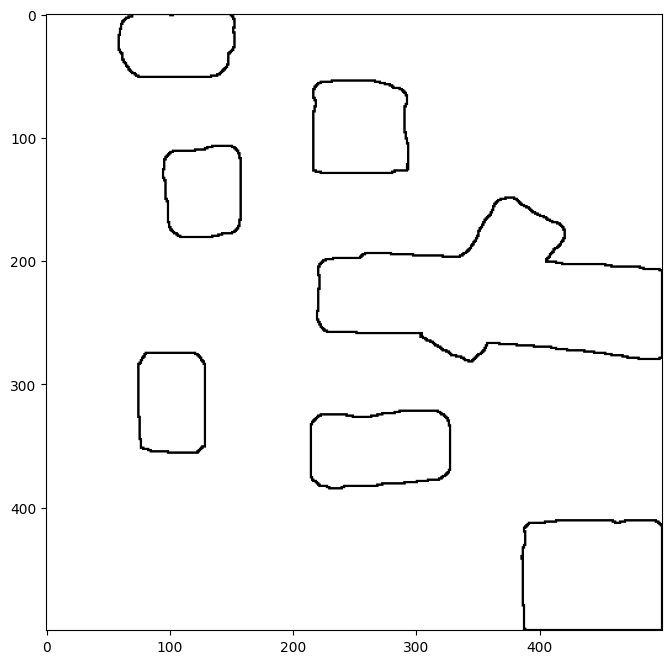

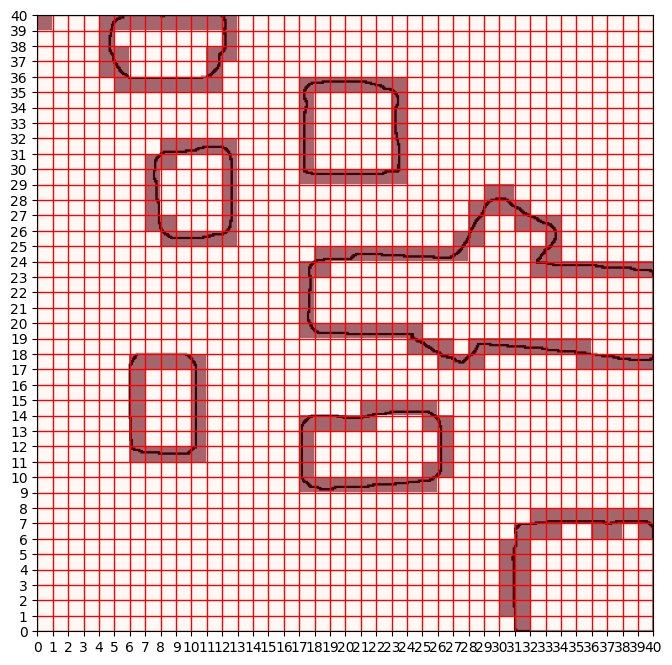

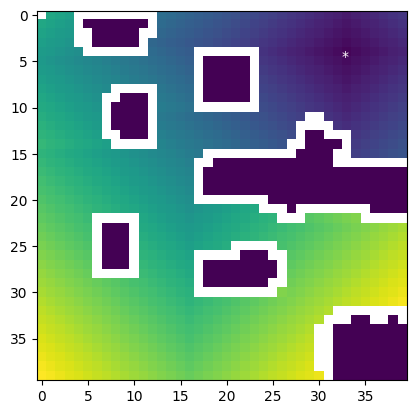

In [138]:
# Abre a imagem e retorna uma matriz numpy dela
img = openImage(imgPath, threshold)

# Cria uma matriz onde será construido o wavefront
# E delemita onde tem objetos
wave = discretizesTheEnvironment(img, map_dims, cell_size, threshold)
plt.show()

# Posições onde tem objetos possuem valor igual a infinito
# Demais posições tem valores -1
initWavefront(wave)

# Calcula o wavefront
waveFront(wave, goal, pos)

# Plota como ficou a wavefront
plt.imshow( wave ) 

# Mostra a onde está o goal
plt.annotate('*', xy=(goal[1]-0.25, goal[0]+0.5), 
                    ha='center', va='center', color='white') 
plt.show()

### Posição do Robô

### Variávies para fazer o Planejamento do Caminho

Variáveis para controlar necessárias para calcular o caminho

Pega a posição do robô e calcula a posição dele no waveFront

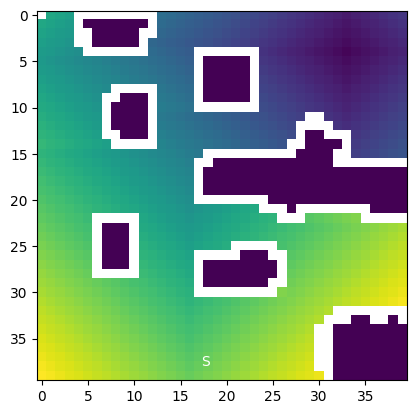

In [139]:
# Plota como ficou a wavefront
plt.imshow( wave ) 

# Mostra a onde está o goal
plt.annotate('S', xy=(start[1]-0.25, start[0]+0.5), 
                    ha='center', va='center', color='white') 
plt.show()


### Faz o robô se mover

[16. -2.]
[-1.9999999999999991, -16.0]
[15. -2.]
[-1.9999999999999991, -15.0]
[14. -2.]
[-1.9999999999999991, -14.0]
[13. -2.]
[-1.9999999999999991, -13.0]
[12. -2.]
[-1.9999999999999993, -12.0]
[11. -2.]
[-1.9999999999999993, -11.0]
[11. -3.]
[-2.999999999999999, -11.0]
[11. -4.]
[-3.999999999999999, -11.0]
[10. -4.]
[-3.9999999999999996, -10.0]
[ 9. -4.]
[-3.9999999999999996, -9.0]
[ 8. -4.]
[-3.9999999999999996, -8.0]
[ 7. -4.]
[-3.9999999999999996, -7.0]
[ 6. -4.]
[-3.9999999999999996, -6.0]
[ 5. -4.]
[-3.9999999999999996, -5.0]
[ 4. -4.]
[-3.9999999999999996, -4.0]
[ 3. -4.]
[-4.0, -3.0000000000000004]
[ 2. -4.]
[-4.0, -2.0000000000000004]
[ 1. -4.]
[-4.0, -1.0000000000000002]
[ 0. -4.]
[-4.0, -2.4492935982947064e-16]
[-1. -4.]
[-4.0, 0.9999999999999998]
[-2. -4.]
[-4.0, 1.9999999999999998]
[-3. -4.]
[-4.0, 2.9999999999999996]
[-4. -4.]
[-4.0, 3.9999999999999996]
[-5. -4.]
[-4.0, 5.0]
[-6. -4.]
[-4.0, 6.0]
[-7. -4.]
[-4.0, 7.0]
[-8. -4.]
[-4.000000000000001, 8.0]
[-9. -4.]
[-4.000

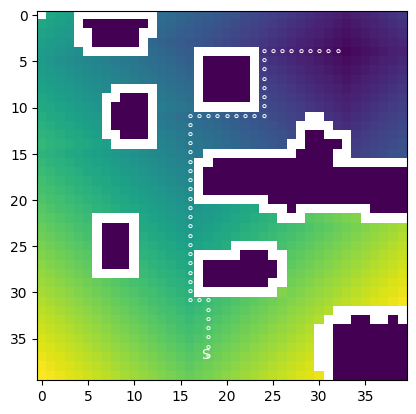

In [140]:
# # Escala Pixel/Metro
# sy, sx = img.shape / map_dims

# An exemple of how to use the api to connet to coppelia
client = RemoteAPIClient()
sim = client.require('sim')
sim.setStepping(True)

sim.startSimulation()

plt.imshow( wave ) 
# Mostra a onde está o goal
plt.annotate('S', xy=(start[1]-0.25, start[0]-0.25), 
                    ha='center', va='center', color='white') 

waveFrontPathPlanning(wave, start, pos, cell_size)

sim.stopSimulation()
